In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pprint import pprint
import numba
from numba import njit
from numba.typed import List, Dict
import correctionlib, rich
import correctionlib.convert
from hist import Hist

/t3home/dvalsecc/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
filename = "root://xrootd-cms.infn.it///store/mc/RunIISummer20UL18NanoAODv9/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/250000/32D0D1A3-74EB-8146-9F3F-B392AB168FDD.root"
#events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=20000).events()

dataset = "ttHTobb"

In [16]:
btagged = (Hist.new.Reg(20, 0, 400,overflow=True, underflow=False, name="pt" )
                .Reg(10, -5, 5, overflow=False, underflow=False, name="eta")
                .Int(0,3, name="flavour")
                .Weight())
non_btagged = (Hist.new.Reg(20, 0, 400,overflow=True, underflow=False, name="pt" )
                .Reg(10, -5, 5, overflow=False, underflow=False, name="eta")
                .Int(0,3, name="flavour")
                .Weight())

In [17]:
bJets = events.Jet[events.Jet.btagDeepFlavB > 0.277]
bJets_L = bJets[bJets.hadronFlavour==0]
bJets_C = bJets[bJets.hadronFlavour==4]
bJets_B = bJets[bJets.hadronFlavour==5]

bJets_flavour = ak.where(bJets.hadronFlavour!=0, bJets.hadronFlavour-3, 0.)

jets_L = events.Jet[events.Jet.hadronFlavour==0]
jets_C = events.Jet[events.Jet.hadronFlavour==4]
jets_B = events.Jet[events.Jet.hadronFlavour==5]

jets_flavour = ak.where(events.Jet.hadronFlavour!=0, events.Jet.hadronFlavour-3, 0.)


In [18]:
print(ak.num(bJets_L))
print(ak.num(bJets_C))
print(ak.num(bJets_B))

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[2, 3, 4, 3, 2, 4, 3, 2, 1, 4, 3, 3, 2, 2, ... 2, 3, 3, 2, 2, 4, 4, 5, 3, 3, 3, 3, 2]


In [19]:
print(ak.num(jets_L))
print(ak.num(jets_C))
print(ak.num(jets_B))

[4, 5, 4, 4, 4, 5, 7, 4, 4, 5, 1, 8, 4, 9, ... 7, 7, 5, 2, 7, 5, 4, 7, 1, 8, 5, 8, 8]
[1, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 0, ... 0, 2, 0, 2, 1, 1, 0, 1, 2, 2, 0, 1, 1]
[4, 3, 4, 4, 3, 4, 3, 3, 1, 4, 4, 4, 4, 3, ... 4, 4, 4, 4, 3, 4, 4, 6, 4, 3, 4, 4, 3]


In [20]:
btagged.fill(ak.flatten(bJets.pt),
             ak.flatten(bJets.eta),
             ak.flatten(bJets_flavour))

Hist(
  Regular(20, 0, 400, underflow=False, name='pt'),
  Regular(10, -5, 5, underflow=False, overflow=False, name='eta'),
  Integer(0, 3, name='flavour'),
  storage=Weight()) # Sum: WeightedSum(value=60613, variance=60613) (WeightedSum(value=61129, variance=61129) with flow)

In [21]:
non_btagged.fill(ak.flatten(events.Jet.pt),
             ak.flatten(events.Jet.eta),
             ak.flatten(jets_flavour))

Hist(
  Regular(20, 0, 400, underflow=False, name='pt'),
  Regular(10, -5, 5, underflow=False, overflow=False, name='eta'),
  Integer(0, 3, name='flavour'),
  storage=Weight()) # Sum: WeightedSum(value=203753, variance=203753) (WeightedSum(value=205004, variance=205004) with flow)

In [22]:
btagged[{"flavour":2}]

Hist(
  Regular(20, 0, 400, underflow=False, name='pt'),
  Regular(10, -5, 5, underflow=False, overflow=False, name='eta'),
  storage=Weight()) # Sum: WeightedSum(value=55513, variance=55513) (WeightedSum(value=55973, variance=55973) with flow)

In [23]:
non_btagged[{"flavour":2}]

Hist(
  Regular(20, 0, 400, underflow=False, name='pt'),
  Regular(10, -5, 5, underflow=False, overflow=False, name='eta'),
  storage=Weight()) # Sum: WeightedSum(value=70961, variance=70961) (WeightedSum(value=71520, variance=71520) with flow)

### Let's save the efficiency in correctionlib format

In [24]:
w_num,  x, y, z = btagged.to_numpy()
num_var = btagged.variances()
w_denom,  x, y, z  = non_btagged.to_numpy()
denom_var = non_btagged.variances()

ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.) 
ratio_err =  np.where( (w_denom>0)&(w_num>0),
                      np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
                      0.)

#recreate the histo
sfhist = ( Hist.new.Reg(20, 0, 400,overflow=True, underflow=False, name="pt" )
                .Reg(10, -5, 5, overflow=False, underflow=False, name="eta")
                .Int(0,3, name="flavour")
           .Double(data=ratio))



/tmp/ipykernel_70613/875839267.py:6: RuntimeWarning: invalid value encountered in divide
  ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.)
/tmp/ipykernel_70613/875839267.py:8: RuntimeWarning: divide by zero encountered in divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_70613/875839267.py:8: RuntimeWarning: invalid value encountered in multiply
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_70613/875839267.py:8: RuntimeWarning: invalid value encountered in divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),


In [34]:
sfhist[:,:,2].values()

array([[1.        , 1.        , 0.46484375, 0.6500956 , 0.74348422,
        0.66372981, 0.63690476, 0.40074906, 1.        , 1.        ],
       [1.        , 1.        , 0.54681275, 0.7460921 , 0.78770632,
        0.78892257, 0.72402188, 0.54207436, 1.        , 1.        ],
       [1.        , 0.01041667, 0.60355781, 0.79617558, 0.82584856,
        0.84335774, 0.76817376, 0.62688615, 1.        , 1.        ],
       [1.        , 1.        , 0.61553785, 0.80558598, 0.85511276,
        0.85104394, 0.81589041, 0.64015905, 1.        , 1.        ],
       [1.        , 1.        , 0.65273312, 0.81129272, 0.84662829,
        0.85413153, 0.79405034, 0.63988095, 1.        , 1.        ],
       [1.        , 1.        , 0.60287081, 0.81456954, 0.8491555 ,
        0.85349612, 0.79440258, 0.64583333, 1.        , 1.        ],
       [1.        , 1.        , 0.68309859, 0.82308846, 0.8496124 ,
        0.8552    , 0.81034483, 0.67213115, 1.        , 1.        ],
       [1.        , 1.        , 0.6052631

In [31]:
sfhist[:,0j,2]

Hist(Regular(20, 0, 400, underflow=False, name='pt'), storage=Double()) # Sum: 16.797938046494373

In [35]:
# without a name, the resulting object will fail validation
sfhist.name = "TRF_efficiencies"
sfhist.label = "out"
clibcorr = correctionlib.convert.from_histogram(sfhist)
clibcorr.description = "Btagging efficiency by pt, eta, flavour"

# set overflow bins behavior (default is to raise an error when out of bounds)
clibcorr.data.flow = "clamp"

cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description="trf efficiency",
    corrections=[clibcorr],
)
rich.print(cset)

with open("test_trf.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

CorrectionSet (schema v2)
trf efficiency
📂
└── 📈 TRF_efficiencies (v0)
    Btagging efficiency by pt, eta, flavour
    Node counts: MultiBinning: 1, Category: 200
    ╭──────────── ▶ input ─────────────╮ ╭──────────── ▶ input ────────────╮ ╭──── ▶ input ────╮
    │ pt (real)                        │ │ eta (real)                      │ │ flavour (int)   │
    │ pt                               │ │ eta                             │ │ flavour         │
    │ Range: [0.0, 400.0), overflow ok │ │ Range: [-5.0, 5.0), overflow ok │ │ Values: 0, 1, 2 │
    ╰──────────────────────────────────╯ ╰─────────────────────────────────╯ ╰─────────────────╯
    ╭─── ◀ output ───╮
    │ out (real)     │
    │ No description │
    ╰────────────────╯

In [36]:
cset = correctionlib.CorrectionSet.from_file("test_trf.json")
corr = cset["TRF_efficiencies"]

In [37]:
corr.evaluate(ak.flatten(bJets.pt), ak.flatten(bJets.eta), ak.flatten(bJets_flavour ))

array([0.62688615, 0.76817376, 0.8491555 , ..., 0.78770632, 0.80558598,
       0.60355781])

# Compute the TRF method

In [82]:
mask = ak.num(events.Jet)>=4
jet_pt = ak.flatten(events[mask].Jet.pt)
jet_eta = ak.flatten(events[mask].Jet.eta)
jet_flavour = ak.where(events[mask].Jet.hadronFlavour!=0, events[mask].Jet.hadronFlavour-3, 0.)
jet_fl = ak.flatten(jet_flavour)

num_jets = ak.num(events[mask].Jet)

bJets = events[mask].Jet[events[mask].Jet.btagDeepFlavB > 0.277]
nBjets = ak.num(bJets)

nGenBJets = ak.sum(jet_flavour==2, axis=1)

In [39]:
cset = correctionlib.CorrectionSet.from_file("test_trf.json")
corr = cset["TRF_efficiencies"]
eff = corr.evaluate(jet_pt, jet_eta, jet_fl)

In [40]:
eff_j = ak.unflatten(eff, num_jets)

In [41]:
eff_j

<Array [[0.0571, 0.646, ... 0.0425, 0.0425]] type='19996 * var * float64'>

## Computing combinations without repetitions

In [11]:
from itertools import combinations, chain
from scipy.special import comb

In [12]:
comb(15, 3, exact=True)

455

In [13]:
list(combinations([0,1,2,3,4,5], 3))

[(0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 3, 4),
 (0, 3, 5),
 (0, 4, 5),
 (1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 3, 4),
 (1, 3, 5),
 (1, 4, 5),
 (2, 3, 4),
 (2, 3, 5),
 (2, 4, 5),
 (3, 4, 5)]

In [14]:
#@numba.jit(nopython=False)
def comb_index(n, k):
    count = comb(n,k, exact=True)
    index = np.fromiter(chain.from_iterable(combinations(range(n), k)), 
                        int, count=count*k)
    return index.reshape(-1, k)

In [15]:
%%timeit
comb_index(15, 4)

199 µs ± 35.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
out = comb_index(10, 3)

### Combinations directly in numba

In [43]:
@njit
def combinations_numba(n, r):
    pool = list(range(n))
    indices = list(range(r))
    empty = not(n and (0 < r <= n))

    if not empty:
        result = [pool[i] for i in indices]
        yield result

    while not empty:
        i = r - 1
        while i >= 0 and indices[i] == i + n - r:
            i -= 1
        if i < 0:
            empty = True
        else:
            indices[i] += 1
            for j in range(i+1, r):
                indices[j] = indices[j-1] + 1

            result = [pool[i] for i in indices]
            yield result

In [81]:
%%timeit
list(combinations_numba(25, 4))

5.22 ms ± 31.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
@numba.jit(nopython=True)
def get_prob_M(M, effs):
    out = np.ones(len(effs))
    iev = 0
    
    for eff in effs:
        #print(eff)
        njets = len(eff)
        
        all_combinations_eff = 0.
        
        for i_comb, comb in enumerate(combinations_numba(njets, M)):
            value = 1.
            for j, ef in zip(range(njets), eff):
                if j in comb:
                    value *= ef
                else:
                    value *= 1-ef
            #Sum the value for this combination to the total
            all_combinations_eff += value      
            
        out[iev] = all_combinations_eff
        iev+=1
    return out

In [27]:
%%timeit
out = get_prob_M(1, eff_j)

67.5 ms ± 9.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%timeit
out = get_prob_M(2, eff_j)

63.6 ms ± 272 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%%timeit
out = get_prob_M(3, eff_j)

982 ms ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%%timeit
out = get_prob_M(4, eff_j)

2.58 s ± 28.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%%timeit
out = get_prob_M(5, eff_j)

4.71 s ± 120 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%%timeit
out = get_prob_M(6, eff_j)

7.07 s ± 102 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
out = get_prob_M(0, eff_j)

In [51]:
out

array([0., 0., 0., ..., 0., 0., 0.])

In [45]:
out = get_prob_M(4, eff_j)

In [46]:
out

array([0.22056752, 0.09948008, 0.30201066, ..., 0.46896965, 0.33150646,
       0.15111263])

(array([102467.,  10744.,   3411.,    393.,    548.,   2077.,   5880.,
         20389.,  41575.,  17734.]),
 array([5.84966364e-04, 1.00526470e-01, 2.00467973e-01, 3.00409476e-01,
        4.00350980e-01, 5.00292483e-01, 6.00233987e-01, 7.00175490e-01,
        8.00116993e-01, 9.00058497e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

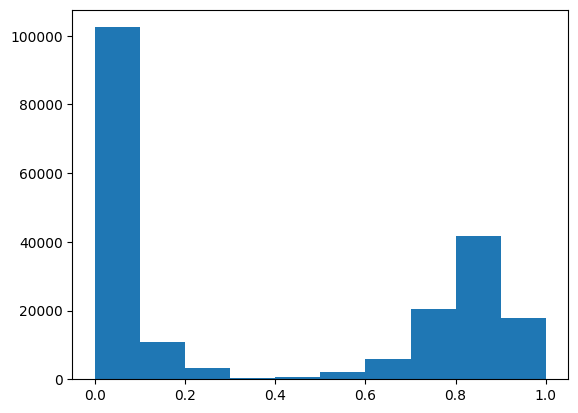

In [47]:
plt.hist(ak.flatten(eff_j))

(array([3.445e+03, 2.813e+03, 1.640e+03, 4.400e+03, 5.383e+03, 1.956e+03,
        3.260e+02, 3.000e+01, 2.000e+00, 1.000e+00]),
 array([0.        , 0.0922161 , 0.18443219, 0.27664829, 0.36886439,
        0.46108049, 0.55329658, 0.64551268, 0.73772878, 0.82994488,
        0.92216097]),
 <BarContainer object of 10 artists>)

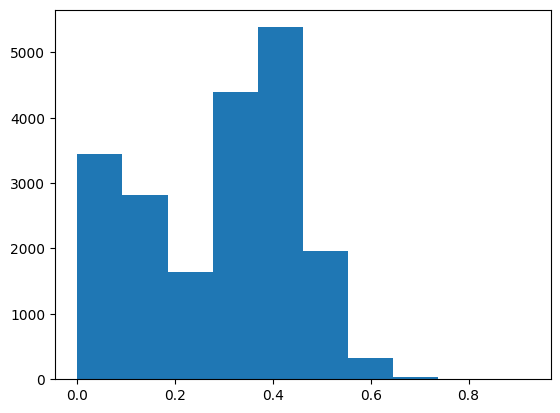

In [48]:
plt.hist(out)

### Now we need the conditional TRF prob

In [63]:
def get_conditiona_TRF(nA, nB, eff_j):
    P_B = np.ones(len(eff_j))
    for i in range(1, nB):  #from 0 to nB-1
        P_B -= get_prob_M(i, eff_j)
    # now the 0 tagged case
    P_B -= ak.to_numpy(ak.prod(1-eff_j, axis=1))
    
    P_A = get_prob_M(nA, eff_j)
    
    return P_A, P_B, P_A/P_B

In [65]:
get_conditiona_TRF(4, 2, eff_j)

(array([0.22056752, 0.09948008, 0.30201066, ..., 0.46896965, 0.33150646,
        0.15111263]),
 array([0.90408825, 0.94759974, 0.99944197, ..., 0.98461874, 0.99912407,
        0.89768091]),
 array([0.2439668 , 0.10498112, 0.30217929, ..., 0.47629568, 0.33179709,
        0.16833669]))

In [66]:
%%timeit
get_conditiona_TRF(4, 2, eff_j)

2.39 s ± 26.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [67]:
P_A, P_B, P_AB = get_conditiona_TRF(4, 2, eff_j)

Text(0, 0.5, 'TRF P(4|2)')

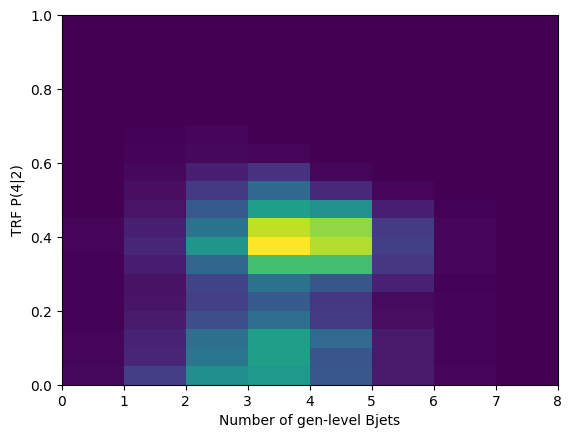

In [84]:
plt.hist2d(ak.to_numpy(nBjets), P_AB, 
          bins=(8, 20), range=((0.,8.),(0.,1.)));
plt.xlabel("Number of gen-level Bjets")
plt.ylabel("TRF P(4|2)")

Text(0, 0.5, 'TRF P(4|2)')

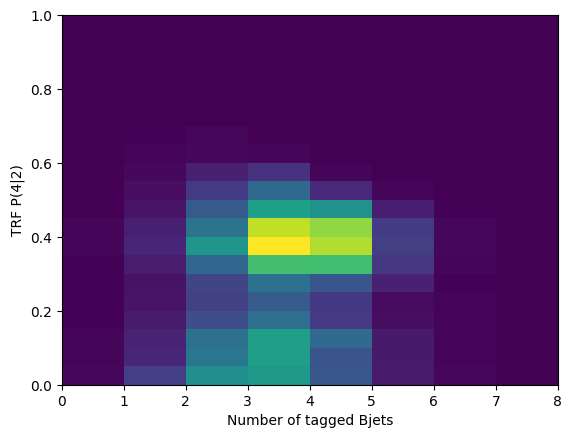

In [79]:
plt.hist2d(ak.to_numpy(nBjets), P_AB, 
          bins=(8, 20), range=((0.,8.),(0.,1.)));
plt.xlabel("Number of tagged Bjets")
plt.ylabel("TRF P(4|2)")